# Homework 2: DDPM

## Section A

In this section, we will implement DDPM (**Denoising Diffusion Probabilistic Models**) on a simple 1D Mixture of Gaussians Model.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^1$.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


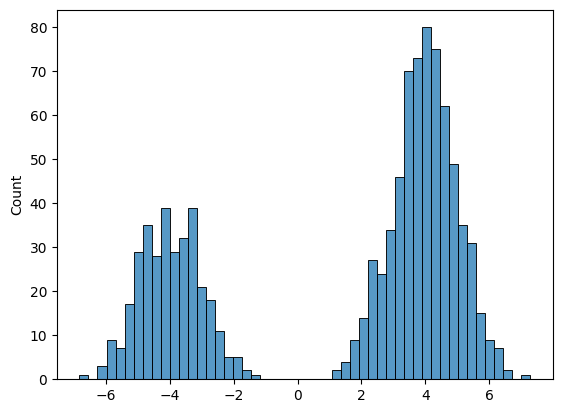

In [2]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0], bins=50)
plt.show()


In [3]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02
ALPHA = 1 - BETA
ALPHA_BAR = [ALPHA ** i for i in range(TIME_STEPS+1)]

Pay attention - beta is constant, hence $x_{t+1}$ is sampled from $q_t = \N(\sqrt{1-\beta}x_t, \sqrt{\beta})$

Implement the following functions to perform ddpm and restore the original given distribution. You can add any other functions required.

In [4]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    ''''
    perform diffusion following equation 2
    returns a list of q(x(t)) and x(t)
    starting from t=0 (i.e., the dataset)
    
    :param data: torch.Size([1000, 1])
    :return samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :return distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    '''
    
    distributions, samples = [None], [data]
    xt = data

    #### ADD YOUR CODE HERE ####
    device = data.device
    
    beta_t = torch.tensor(beta, device=device)
    one_minus_beta = torch.tensor(1. - beta, device=device)
    
    for t in range(steps):
        mean = torch.sqrt(one_minus_beta) * xt
        std = torch.sqrt(beta_t)
        
        distribution = torch.distributions.Normal(mean, std)
        xt = distribution.rsample()
        
        distributions.append(distribution)
        samples.append(xt)
    #### DONE WITH SOLUTION ####     
    return distributions, samples


Sample and visualize realizations of the forward/diffusion process over time, using samples from do_diffusion(dataset)

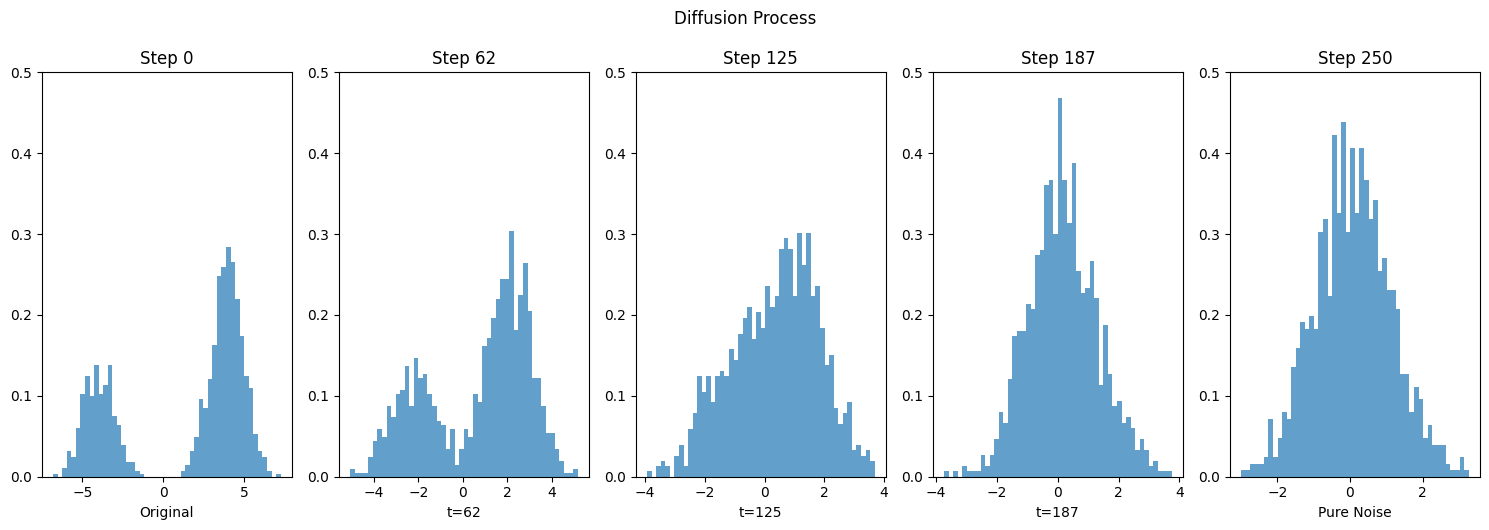

In [5]:
_, samples = do_diffusion(dataset)
#### ADD YOUR CODE HERE ####
def visualize_diffusion(samples, num_points=5):
    indices = np.linspace(0, len(samples)-1, num_points, dtype=int)
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        sample = samples[idx]
        if sample is None:
            continue
        plt.subplot(1, num_points, i+1)
        plt.hist(sample.cpu().numpy(), bins=50, density=True, alpha=0.7)
        plt.title(f"Step {idx}")
        plt.ylim(0, 0.5)
        plt.xlabel("Original" if idx == 0 else "Pure Noise" if idx == len(samples)-1 else f"t={idx}")
    
    plt.tight_layout()
    plt.suptitle("Diffusion Process", y=1.05)
    plt.show()

visualize_diffusion(samples)
#### DONE WITH SOLUTION ####

# Training
We first use the loss in Equation 3 in the paper without any of the optimizations presented later, which a play significant role for complex, real-world distributions.

Diffusion models are trained by first corrupting the training examples, then trying to reconstruct the cleaner examples from the noisy examples at each step of the corruption process. The loss is an upper bound on the negative log likelihood:

$L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} 
\right]$

Where the generative model, also called reverse process, has form:

$p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added. Intuitively, we are training these networks to maximize the predicted probability of observing the uncorrputed example $x_{t-1}$ based on $x_t$ , i.e., the term $p_\theta(x_{t-1}\vert x_t)$ in the loss, for each diffusion step. Remember that $x_t$ was generated earlier from $x_{t-1}$ by adding noise; the networks have to learn to undo the noise. The other terms in the loss involving $q(x_t\vert x_{t-1})$ are not necessary to learn a good generative model, since they are constant, but are useful as a “frame of reference” to make a “perfect” generative model achieve a loss of 0.

You should implement the loss in the function below. This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [6]:
def compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model):
    """
    Implements the loss from Equation 3 of the DDPM paper.
    Compares predicted p_theta(x_{t-1} | x_t) to forward q(x_t | x_{t-1})

    :param forward_distributions: list of q(x_t | x_{t-1}) distributions (not directly used here)
    :param forward_samples: list of samples [x_0, x_1, ..., x_T]
    :param mean_model: model predicting μ_θ(x_t, t)
    :param var_model: model predicting σ²_θ(x_t, t)
    """
    # ### ADD YOUR CODE HERE ####
    device = forward_samples[-1].device
    xt = forward_samples[-1]
    batch_size = xt.shape[0]
    
    # Prior term using first function's approach
    p_xt = torch.distributions.Normal(torch.zeros_like(xt), torch.ones_like(xt))
    log_p_xt = (-p_xt.log_prob(xt)).mean()
    
    # Using running sum like the first function instead of collecting terms
    temp_loss = 0
    for t in range(1, len(forward_samples)):
        xt_minus_one = forward_samples[t - 1]
        xt = forward_samples[t]
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=device)
        
        # Get the forward distribution
        q_dist = forward_distributions[t]
        
        # Predict reverse process
        mu_t = mean_model(xt, t_tensor)
        sigma_t = var_model(xt, t_tensor)
        p_theta = torch.distributions.Normal(mu_t, sigma_t)
        
        # Compute log probs without summing over dimensions
        temp_loss += (p_theta.log_prob(xt_minus_one) - q_dist.log_prob(xt))
    
    loss = log_p_xt - temp_loss.mean()
    return loss / len(forward_samples) 



We also implement and use the loss in Equation 12 in the paper with the suggested optimizations presented.

In [7]:
def compute_loss_equation12(forward_samples, noise_model):
    """
    Compute the loss in equation 12
    forward = q , reverse = p
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param noise_model: torch.nn.Module
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####
    x0 = forward_samples[0]
    batch_size = x0.shape[0]
    device = x0.device
    all_losses = []

    for _ in range(TIME_STEPS):
        alpha_t = ALPHA  
        beta_t = BETA 
        sigma2_t = beta_t
        
        t = torch.randint(1, TIME_STEPS + 1, (batch_size, 1), device=device).float()
        t_index = t.squeeze().long()  #indexing alpha_bar
        epsilon = torch.randn_like(x0)

        # Get precomputed cumulative product of alphas: ᾱ_t
        alpha_bar_t = torch.tensor([ALPHA_BAR[ti.item()] for ti in t_index], device=device).view(-1, 1)

        # Generate x_t from x_0 using the forward diffusion equation
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * epsilon

        # Predict the noise ε_θ from x_t and timestep t
        epsilon_pred = noise_model(xt, t)

        omega_t = ((1 - alpha_t) ** 2) / (2 * alpha_t * (1 - alpha_bar_t) * sigma2_t)
        omega_t = omega_t.view(-1, 1)  # match shape with loss

        # Compute the weighted mean squared error
        mse_loss = (omega_t * (epsilon - epsilon_pred).pow(2)).mean()
        all_losses.append(mse_loss)

    # Average over sampled time steps
    return torch.stack(all_losses).mean()
    #### DONE WITH SOLUTION ####


In [8]:
def compute_loss(equation, forward_distributions, forward_samples, mean_model, var_model, noise_model):
    """
    Compute the loss according to the given equation (just a wrapper)
    :param equation: int
    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####
    if equation == 3:
        return compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model)
    return compute_loss_equation12(forward_samples, noise_model)
    #### DONE WITH SOLUTION #### 

Now define three very simple neural networks to predict the mean/variance/noise, and an optimizer.

These networks take two inputs: the noisy sample $x_t$ and the normalized time-step t. The time-step is added as an additional column feature, and, since the input is also one-dimensional, the total input size is two.

When you are happy with your simple model architecure, show the training curve for both equations.

In [9]:
#### ADD YOUR CODE HERE ####
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        if len(t.shape) == 1:
            t = t.view(-1, 1)
        t_norm = t / TIME_STEPS
        x_input = torch.cat([x, t_norm], dim=1)
        return self.net(x_input)
class ModelVAR(nn.Module):
    def __init__(self):
        super(ModelVAR, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        
        # Simple weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                
    def forward(self, x, t):
        if len(t.shape) == 1:
            t = t.view(-1, 1)
        t = t.to(x.device)
        t_norm = t / TIME_STEPS
        x_input = torch.cat([x, t_norm], dim=1)
        return F.softplus(self.net(x_input))


class ModelMean(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Simple weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                
    def forward(self, x, t):
        if len(t.shape) == 1:
            t = t.view(-1, 1)
        t = t.to(x.device) 
        t_norm = t / TIME_STEPS
        x_input = torch.cat([x, t_norm], dim=1)
        return self.net(x_input)


mean_model = ModelMean()
var_model = ModelVAR()
noise_model = SimpleMLP()
#### DONE WITH SOLUTION ####

In [10]:
import torch.nn.functional as F

def train_loop(dataset, mean_model, var_model, noise_model, optim_simple, optim_noise,Equation_number): #I added Equation_number after a follow-up to a question in the forum.
    """
    Train the model
    :param dataset: torch.Size([1000, 1])
    :param mean_model: Optional(torch.nn.Module)
    :param var_model: Optional(torch.nn.Module)
    :param noise_model: Optional(torch.nn.Module)
    :param optim_mean: torch.optim
    :param optim_var: torch.optim
    :param optim_noise: torch.optim
    :return: eq3_loss_history, eq12_loss_history
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_history = []

    bar = tqdm(range(200))

    for epoch in bar:
        # regenerate diffusion samples each epoch
        forward_distributions, forward_samples = do_diffusion(dataset)

        if Equation_number == 3:
            loss_eq3 = compute_loss(3, forward_distributions, forward_samples, mean_model, var_model, None)
            optim_simple.zero_grad()
            loss_eq3.backward()
            optim_simple.step()
            loss_history.append(loss_eq3.item())

        else:
            optim_noise.zero_grad()
            loss_eq12 = compute_loss(12, forward_distributions, forward_samples, None, None, noise_model)
            loss_eq12.backward()
            optim_noise.step()
            loss_history.append(loss_eq12.item())

        if epoch % 100 == 0:
            if Equation_number == 3:
                print(f"Epoch {epoch + 1}/200 | Eq3: {loss_eq3.item():.4f}")
            else:
                print(f"Epoch {epoch + 1}/200 | Eq12: {loss_eq12.item():.4f}")

    return loss_history

optim_simple = torch.optim.Adam(list(mean_model.parameters()) +list(var_model.parameters()), lr=1e-2)
optim_noise = torch.optim.Adam(noise_model.parameters(), lr=1e-3, weight_decay=1e-5)

eq3_loss_history = train_loop(dataset, mean_model, var_model, noise_model, optim_simple, optim_noise,3)
eq12_loss_history = train_loop(dataset, mean_model, var_model, noise_model, optim_simple, optim_noise, 12)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 | Eq3: 5.0517
Epoch 101/200 | Eq3: 0.0115


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 | Eq12: 0.0219
Epoch 101/200 | Eq12: 0.0125


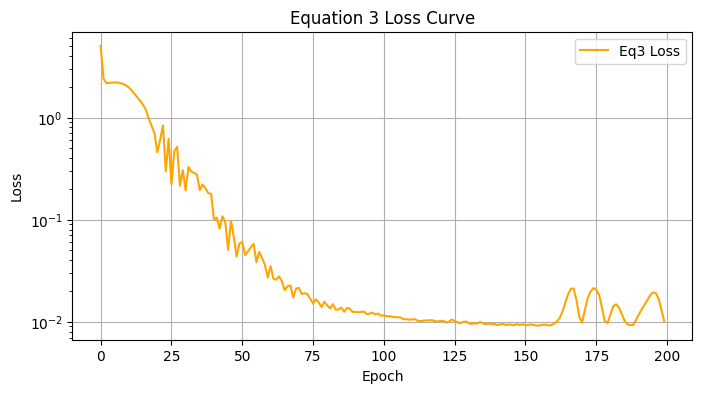

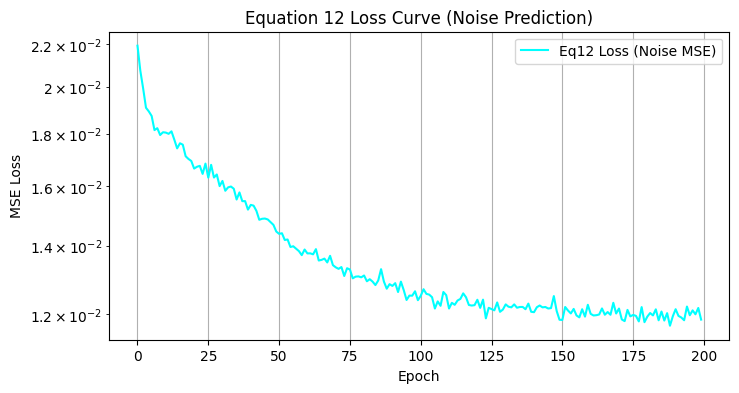

In [11]:
#I changed it into two plots here instead of the one you provided
# --- Plot 1: Equation 3 Loss ---
plt.figure(figsize=(8, 4))
plt.plot(eq3_loss_history, label="Eq3 Loss", color='orange')
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Equation 3 Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: Equation 12 Loss ---
plt.figure(figsize=(8, 4))
plt.plot(eq12_loss_history, label="Eq12 Loss (Noise MSE)", color='cyan')
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Equation 12 Loss Curve (Noise Prediction)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def save_model(model, filepath):
    """
    Save the PyTorch model to a file.
    
    Args:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The path to save the model file.
    """
    torch.save(model.state_dict(), filepath)
    print("Model saved successfully.")

def load_model(model_class, filepath):
    """
    Load a PyTorch model from a file.
    
    Args:
        model_class (torch.nn.Module): The class of the PyTorch model to load.
        filepath (str): The path to the saved model file.
        
    Returns:
        model (torch.nn.Module): The loaded PyTorch model.
    """
    model_type = filepath.split("/")[-1].split("_")[0]
    #### ADD YOUR CODE HERE ####
    if model_type == "mean" or model_typ == "var" or model_type == "noise":
        # Use SimpleNetwork with the same architecture as original models
        model = SimpleNetwork(input_dim=2, hidden_dim=32, output_dim=1)
    else:
        raise ValueError("Invalid model type.")
    #### DONE WITH SOLUTION ####  
      
    model.load_state_dict(torch.load(filepath), strict=False)
    model.eval()
    print("Model loaded successfully.")
    return model

#Used kaggle so I kept this in comment if relevant uncomment this
    
# save_model(mean_model, "models/mean_model.pth")
# save_model(var_model, "models/var_model.pth")
# save_model(noise_model, "models/noise_model.pth")


# mean_model = load_model(torch.nn.Sequential, "models/mean_model.pth")
# var_model = load_model(torch.nn.Sequential, "models/var_model.pth")
# noise_model = load_model(torch.nn.Sequential, "models/noise_model.pth")

# Sampling
Implement the original paper's sampling procedure, for both equations 3,12

In [13]:
from tqdm import trange
def sample_reverse_equation3(mean_model, var_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 3
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    xt = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1)).sample() # start from a noise
    samples_history = [xt]
    for t in reversed(range(0,steps)):
      time_tensor = torch.full((count, 1), t, dtype=torch.float32)
      mu_thata = mean_model(xt,time_tensor)
      var_theta = var_model(xt,time_tensor)
      xt = torch.distributions.Normal(mu_thata,var_theta).sample()
      # xt = torch.distributions.Normal(mu_thata,var_theta).rsample()
      samples_history.append(xt)

    #### DONE WITH SOLUTION ####
    return samples_history
    

def sample_reverse_equation12(noise_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 12
    :param noise_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    xt = torch.randn(count, 1)
    # sample_history = [xt]
    sample_history = [xt.clone()]

    for t in reversed(range(1, steps + 1)):
        t_tensor = torch.full((count, 1), t, dtype=torch.float32)
        eps_theta = noise_model(xt, t_tensor)
        alpha_t = ALPHA
        alpha_bar_t = ALPHA_BAR[t]
        mu_theta = (1 / alpha_t**0.5) * (
            xt - ((1 - alpha_t) / (1 - alpha_bar_t)**0.5) * eps_theta)
        beta_t = BETA
        std = beta_t**0.5
        eps = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)
        xt = mu_theta + std * eps
        sample_history.append(xt.clone())
        # sample_history.append(xt.clone())
    #### DONE WITH SOLUTION ####

    return sample_history

In [21]:
def sample_reverse(equation, mean_model, var_model, noise_model, count, steps=1000):
    """
    Sample from the reverse process using the given equation, it's a wrapper
    :param equation: int
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    if equation == 3:
        return sample_reverse_equation3(mean_model, var_model, count, steps)
    elif equation == 12:
        return sample_reverse_equation12(noise_model, count, steps)
    else:
        raise ValueError("Equation must be either 3 or 12.")
    #### DONE WITH SOLUTION ####

Show us your reverse sampling, x axis is time, y axis it the sampled process realization value.

Afterwards, compare the original distribution, with each of the estimated distributions, seperatly. 

Add at the end of this section, where do you think the diffrence between the FIDs and the charts is coming from.

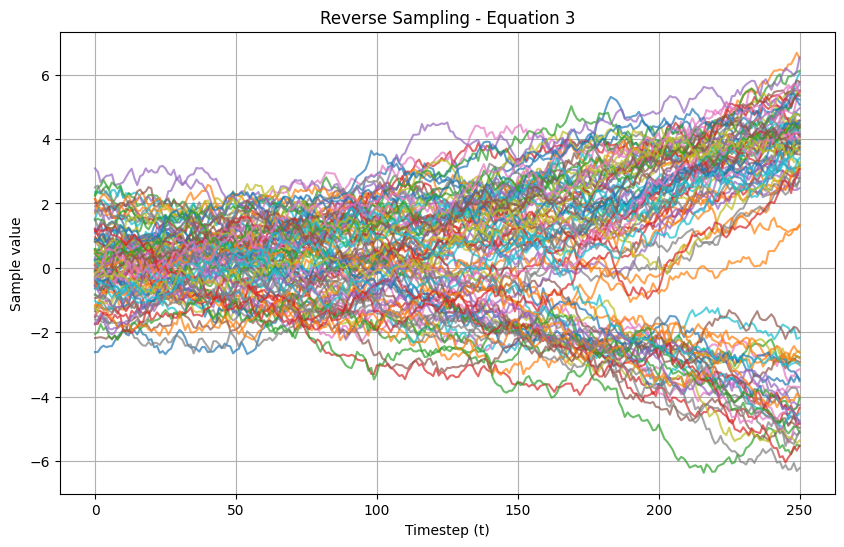

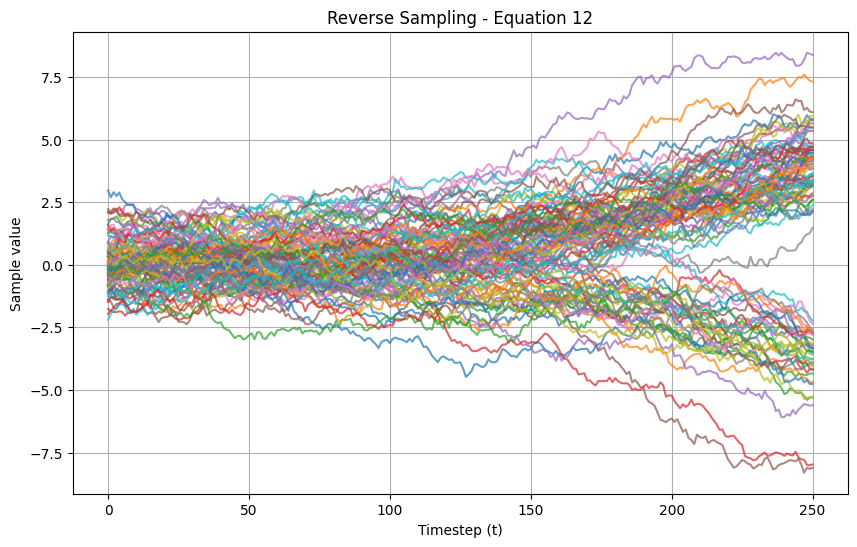

In [14]:
#### ADD YOUR CODE HERE ####
def plot_sample_trajectories(sample_history, title, num_trajectories=100):
    """
    Plot sample trajectories over time from reverse process.

    :param sample_history: list of [count, 1] tensors (from sample_reverse_*)
    :param title: str
    :param num_trajectories: how many individual samples to show
    """
    steps = len(sample_history)
    samples = torch.stack(sample_history)[:, :num_trajectories, 0]  # [steps, N]

    plt.figure(figsize=(10, 6))
    for i in range(num_trajectories):
        plt.plot(range(steps), samples[:, i].detach().cpu().numpy(), alpha=0.7)
    plt.xlabel("Timestep (t)")
    plt.ylabel("Sample value")
    plt.title(title)
    plt.grid(True)
    plt.show()

samples_eq3 = sample_reverse_equation3(mean_model, var_model, count=100)
plot_sample_trajectories(samples_eq3, title="Reverse Sampling - Equation 3",num_trajectories=100)
samples_eq12 = sample_reverse_equation12(noise_model, count=250)
plot_sample_trajectories(samples_eq12, title="Reverse Sampling - Equation 12",num_trajectories=100)
#### DONE WITH SOLUTION ####

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


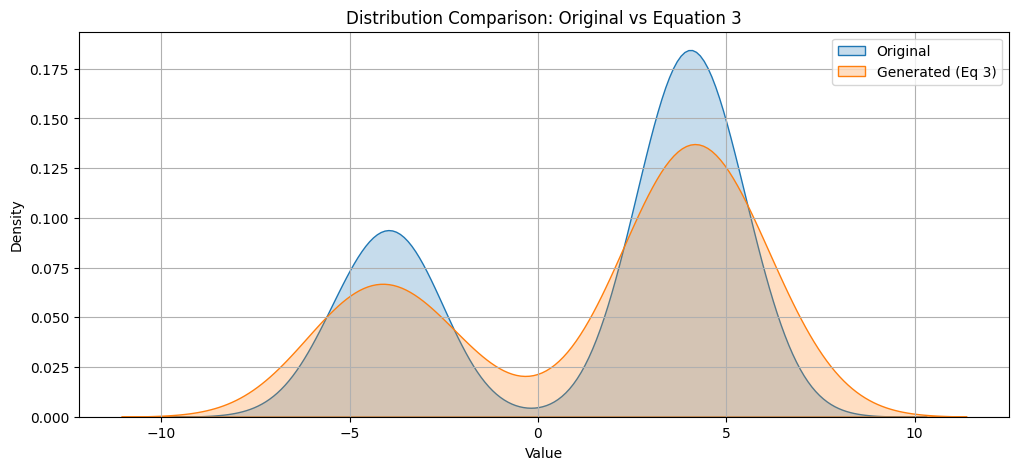

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


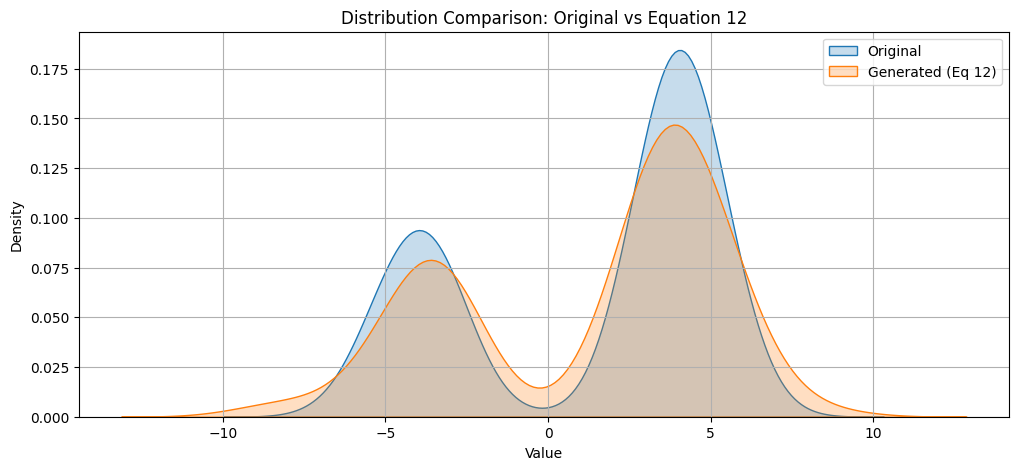

In [22]:
#### ADD YOUR CODE HERE ####
final_samples_eq3 = samples_eq3[-1].detach().cpu().numpy()
final_samples_eq12 = samples_eq12[-1].detach().cpu().numpy()
original_data = dataset.cpu().numpy()

plt.figure(figsize=(12, 5))
sns.kdeplot(original_data.flatten(), label='Original', fill=True)
sns.kdeplot(final_samples_eq3.flatten(), label='Generated (Eq 3)', fill=True)
plt.title('Distribution Comparison: Original vs Equation 3')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.kdeplot(original_data.flatten(), label='Original', fill=True)
sns.kdeplot(final_samples_eq12.flatten(), label='Generated (Eq 12)', fill=True)
plt.title('Distribution Comparison: Original vs Equation 12')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
#### DONE WITH SOLUTION ####

In [23]:
#Changed

import numpy as np
import torch
from scipy.linalg import sqrtm

def compare_fid(equation,
                data_distribution,
                mean_model,
                var_model,
                noise_model,
                count=10000):
    """
    Calculate the FID between the target distribution and the generated samples
    drawn via equation 3 or equation 12 reverse processes.

    :param equation: int, either 3 or 12
    :param data_distribution: MixtureSameFamily
    :param mean_model: nn.Module used for eq 3
    :param var_model: nn.Module  used for eq 3
    :param noise_model: nn.Module used for eq 12
    :param count: number of samples
    :return: float FID
    """
    real = data_distribution.sample((count, 1)).cpu().numpy().reshape(count, -1)
    noise_model.eval(); mean_model.eval(); var_model.eval()
    
    with torch.no_grad():
        history = sample_reverse(
            equation=equation,
            mean_model=mean_model,
            var_model=var_model,
            noise_model=noise_model,
            count=count,
            steps=TIME_STEPS
        )
    gen = history[-1].cpu().numpy().reshape(count, -1)

    # 3) Empirical means & covariances
    mu_r = np.mean(real, axis=0)
    mu_g = np.mean(gen,  axis=0)
    σ_r  = np.atleast_2d(np.cov(real, rowvar=False))
    σ_g  = np.atleast_2d(np.cov(gen,  rowvar=False))

    # 4) Matrix square root term
    covmean = sqrtm(σ_r.dot(σ_g))
    if np.iscomplexobj(covmean):
        covmean = np.real(covmean)

    # 5) Frechet distance
    diff = mu_r - mu_g
    fid = diff.dot(diff) + np.trace(σ_r + σ_g - 2 * covmean)
    return float(fid)



fid_eq3  = compare_fid(3,  data_distribution, mean_model, var_model, noise_model, count=10000)
fid_eq12 = compare_fid(12, data_distribution, mean_model, var_model, noise_model, count=10000)

print(f"FID (Equation 3) : {fid_eq3:.4f}")
print(f"FID (Equation 12): {fid_eq12:.4f}")

FID (Equation 3) : 0.0329
FID (Equation 12): 0.0388


Equation 12 trains the model to predict the noise at each timestep. This is easier for the model and helps it remove noise more precisely. Equation 3 makes the model learn both the mean and the variance at every reverse step. Small errors in variance estimation cause the generated samples to become too spread out. The loss in Equation 12 gives more weight to early timesteps when there is more noise, so the model learns to correct large noise more effectively. For these reasons, Equation 12 produces samples whose mean and covariance match the real distribution more closely and therefore achieves a lower FID

## Section B

In this section, we will implement DDPM on multidimentional, unknown distribution.
Same as in previous section, will be based on the original DDPM paper by ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))

In [24]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

### Network helpers

In [25]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$.


In [26]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block.

In [27]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. 


In [28]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization.

In [29]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
* at the middle of the network, again ResNet blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
* finally, a ResNet block followed by a convolutional layer is applied.

Watch carefully every element of this architecture, what it is doing, which input shape and output shape it has.

In [30]:
class Unet(nn.Module):
    """
    Unet architecture for diffusion models
    the network takes a batch of noisy images of shape (batch_size, num_channels, height, width)
    and a batch of noise levels of shape (batch_size, 1) as input
    and returns a tensor of shape (batch_size, num_channels, height, width)
    """
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=1
    ):
        super().__init__()
        #### ADD YOUR CODE HERE ####
        # input channels
        self.channels = channels
        # set initial dimension to default
        init_dim = default(init_dim, dim)
        # conv layer to proccess input data
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        # dimension calculation for each layer (*map = unpacks the map the flat list)
        dimensions = [init_dim, *map(lambda m: dim * m, dim_mults)]

        # tuple of dimensions between each two input output layers
        input_output_dim = list(zip(dimensions[:-1], dimensions[1:]))

        # time embedding setup
        self.with_time_emb = with_time_emb
        if with_time_emb:
            time_dim = dim * 4
            # time embedding with mlp
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),  # convert time to sinusoidal embeddings
                nn.Linear(dim, time_dim),           # higher dimension linear layer
                nn.GELU(),                          # activation function
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None

        # Store dimensions for debugging

        # Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
        self.downsample = nn.ModuleList([])
        for index, (dim_in, dim_out) in enumerate(input_output_dim):
            is_last_downsample = index == len(input_output_dim) - 1
            self.downsample.append(nn.ModuleList([
                # 1st ResNet block changes dim_in to dim_out
                ResnetBlock(dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                # 2nd ResNet block maintains new dimension
                ResnetBlock(dim_out, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                # groupnorm + attention (optionally linear) + residual connection
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                # downsample apart from the last layer
                Downsample(dim_out) if not is_last_downsample else nn.Identity()
            ]))

        # middle of the network -  ResNet blocks are applied, interleaved with attention
        mid_dim = dimensions[-1]
        self.mid_first_block = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attention = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_second_block = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        # upsampling - Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
        self.upsample = nn.ModuleList([])
        for index, (dim_in, dim_out) in enumerate(reversed(input_output_dim)):
            is_last_upsample = index >= len(input_output_dim) - 1
            self.upsample.append(nn.ModuleList([
                # 1st ResNet block processes concatenated skip connection
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                # 2nd ResNet block
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                # groupnorm + attention (optionally linear) + residual connection
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                # upsample apart from the last layer
                Upsample(dim_in) if not is_last_upsample else nn.Identity()
            ]))

        # finally, a ResNet block followed by a convolutional layer is applied.
        self.final_conv = nn.Sequential(
            ResnetBlock(dim, dim, time_emb_dim=time_dim),
            nn.Conv2d(dim, channels, 1)
        )
        #### DONE WITH SOLUTION ####

    def forward(self, x, time):
        """
        :param x: torch Tensor of shape (batch_size, channels, height, width)
        :param time: torch Tensor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, channels, height, width)
        """

        #### ADD YOUR CODE HERE ####
        x = self.init_conv(x)
        h = x
        
        # ensure time is a 1D tensor of shape (batch,)
        if time is not None and time.dim() == 2:
            time = time.squeeze(-1)  # (batch, 1) -> (batch,)
        
        # Process position embeddings for noise levels
        if self.with_time_emb and time is not None:
            t = self.time_mlp(time)      # might be (batch, 1, time_dim)
        else:
            t = None

        # skip connections
        h_skips = []

        # applying downsampling stages
        for resnet1, resnet2, attn, downsample in self.downsample:
            h = resnet1(h, t)
            h = resnet2(h, t)
            h = attn(h)
            h_skips.append(h)
            h = downsample(h)

        # applying middle blocks
        h = self.mid_first_block(h, t)
        h = self.mid_attention(h)
        h = self.mid_second_block(h, t)

        # applying upsampling stages
        for resnet1, resnet2, attn, upsample in self.upsample:
            skip = h_skips.pop()
            h = torch.cat((h, skip), dim=1)  #concat with skip connections
            h = resnet1(h, t)
            h = resnet2(h, t)
            h = attn(h)
            h = upsample(h)

        # applying final ResNet block and convolution
        h = self.final_conv(h)
        return h
        #### DONE WITH SOLUTION ####

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$, according to a **variance schedule**.

Implement both.

In [31]:
def linear_beta_schedule(timesteps):
    """
    set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    :param timesteps: int
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    beta_start = 0.0001
    beta_end = 0.02
    #### DONE WITH SOLUTION ####
    return torch.linspace(beta_start, beta_end, timesteps)
    

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672))
    :param timesteps: int
    :param s: float
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    #### DONE WITH SOLUTION ####
    return torch.clip(betas, 0.0001, 0.9999)
    

To start with, let's use the linear schedule for $T=200$ time steps.

Define the variables $\beta_t$, $\alpha_t$ for each $t$, the cumulative product of the variances $\bar{\alpha}_t$, and every other variable that is helpful.

Each should be a 1-dimensional tensors, storing values from $t$ to $T$. Later use the extact function to extract the appropriate $t$ index for a batch of indices.


In [32]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)


# define alphas
#### ADD YOUR CODE HERE ####
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
#### DONE WITH SOLUTION ####

# calculations for diffusion q(x_t | x_{t-1}) and others
#### ADD YOUR CODE HERE ####
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
#### DONE WITH SOLUTION ####

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    # extracts the appropriate $t$ index for a batch of indices
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

From the DPPM paper:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$.

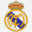

In [33]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
from PIL import Image
import requests

image_size = 32
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

url = 'https://icon2.cleanpng.com/20180501/hte/avs0hy67c.webp'
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
x_start.shape
reverse_transform(x_start.squeeze())

### Forward/ Diffusion process ###

In [34]:
# forward diffusion q(x_t | x_0)
def q_sample(x_start, t, noise=None):
    """
    q_sample function for diffusion process
    :param x_start: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param noise: Optional(torch.Tensor) = None
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####
    if noise is None:
        noise = torch.randn_like(x_start)


    #extracting the right scaling factors for the sampling at timestep t
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    #applying the forward diffusion process equation  q(x_t | x_0) = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    #### DONE WITH SOLUTION ####

Test your result on a particular time step:

In [35]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

#### ADD YOUR CODE HERE ####
#converting scalar timestep to tensor
t = torch.tensor([100])
noisy_image = get_noisy_image(x_start, t)
timesteps_to_test = [0, 50, 100, 150, 199]
images = []

for timestep in timesteps_to_test:
    t = torch.tensor([timestep])
    noisy_img = get_noisy_image(x_start, t)
    images.append(noisy_img)
#### DONE WITH SOLUTION ####

Now visualize this for various time steps:

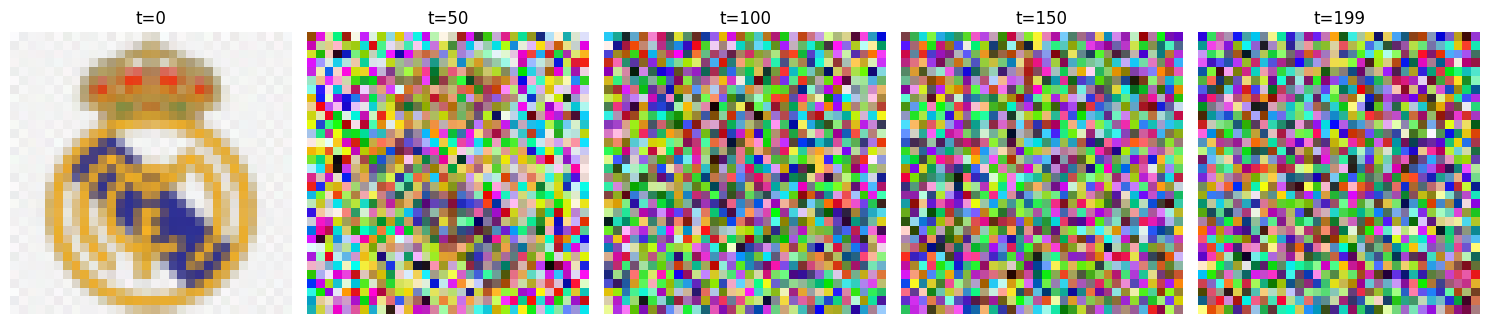

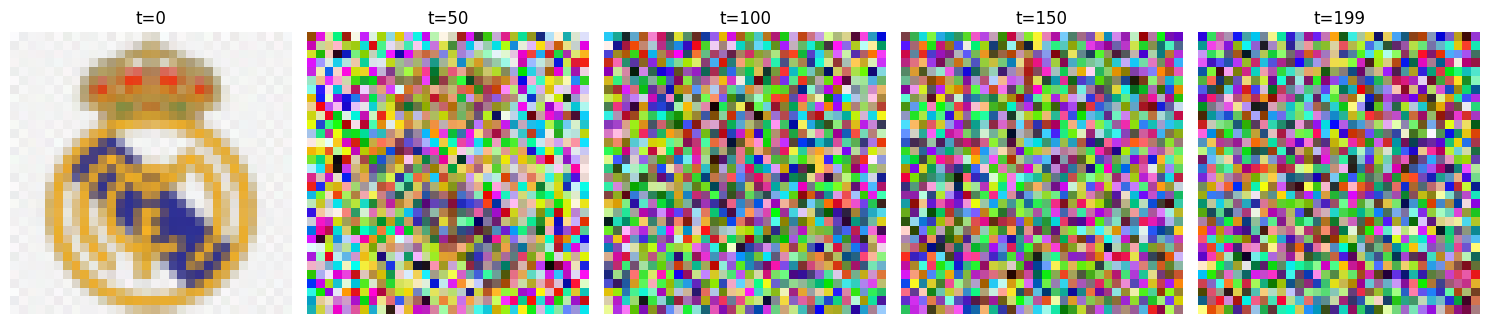

In [36]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

#### ADD YOUR CODE HERE ####
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plot a list of images in a grid.
    :param imgs: list of images to plot
    :param with_orig: bool, whether to include the original image
    :param row_title: list of titles for each row
    :param imshow_kwargs: additional arguments for imshow
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    num_imgs = len(imgs)
    if with_orig:
        num_imgs += 1
    
    fig, axs = plt.subplots(1, num_imgs, figsize=(15, 5))
    if num_imgs == 1:
        axs = [axs]
    
    # If with_orig is True, show the original image
    if with_orig:
        axs[0].imshow(np.array(reverse_transform(x_start.squeeze())), **imshow_kwargs)
        axs[0].set_title('Original')
    
    # Display each image in the list
    for i, img in enumerate(imgs):
        ax_idx = i + 1 if with_orig else i
        if isinstance(img, torch.Tensor):
            img = reverse_transform(img)
        axs[ax_idx].imshow(np.array(img), **imshow_kwargs)
        
        # Set title with timestamp
        if row_title is not None:
            axs[ax_idx].set_title(row_title[i])
        else:
            # If specific titles aren't provided, use default "t=X" format
            timesteps = [0, 50, 100, 150, 199]  # Default timesteps
            if i < len(timesteps):
                axs[ax_idx].set_title(f"t={timesteps[i]}")
    
    for ax in axs:
        ax.axis('off')
    
    fig.tight_layout()
    plt.show()
    return fig
#### DONE WITH SOLUTION ####

plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


Define the loss function given the model. Use the U-Net defined above.


In [37]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    #### ADD YOUR CODE HERE ####
    x_noise = q_sample(x_start,t,noise = noise)
    predicted_noise = denoise_model(x_noise,t)
    ### DONE WITH SOLUTION ####

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define a PyTorch Dataset + DataLoader

The dataset is Fashion-MNIST, to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist). 
The images suppose to be 28x28 grayscale images, scaled linearly to $[-1, 1]$.

Implement a PyTorch Dataset class that loads the images and applies wanted transformations on-the-fly, and a DataLoader to load the dataset in batches.


In [38]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

#### ADD YOUR CODE HERE ####
transform = transforms.Compose([
            transforms.ToTensor(), #converting to tensor and scaleing to [0, 1]
            transforms.Lambda(lambda t: (t*2) - 1) #scaling to [-1, 1]
        ])

class FashionMNISTDataset(Dataset):
    """
    Dataset class for Fashion-MNIST dataset
    """
    def __init__(self,split='train',transform = None):
        """
        Initialize the dataset
        :param split: str, either "train" or "test"
        """
        self.data = load_dataset("fashion_mnist", split=split)
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Return the item at index idx
        :param idx: int, index of the item to return
        :return: torch.Tensor of shape (1, 28, 28), the image scaled to [-1, 1]
        
        """
        image = self.data[idx]["image"]
        image = self.transform(image)
        
        return image
#datasets creation
batch_size = 64
dataset = FashionMNISTDataset(split='train+test', transform=transform)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#### DONE WITH SOLUTION ####


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Sampling

Implement sampling algorithm 2 from the original paper: 

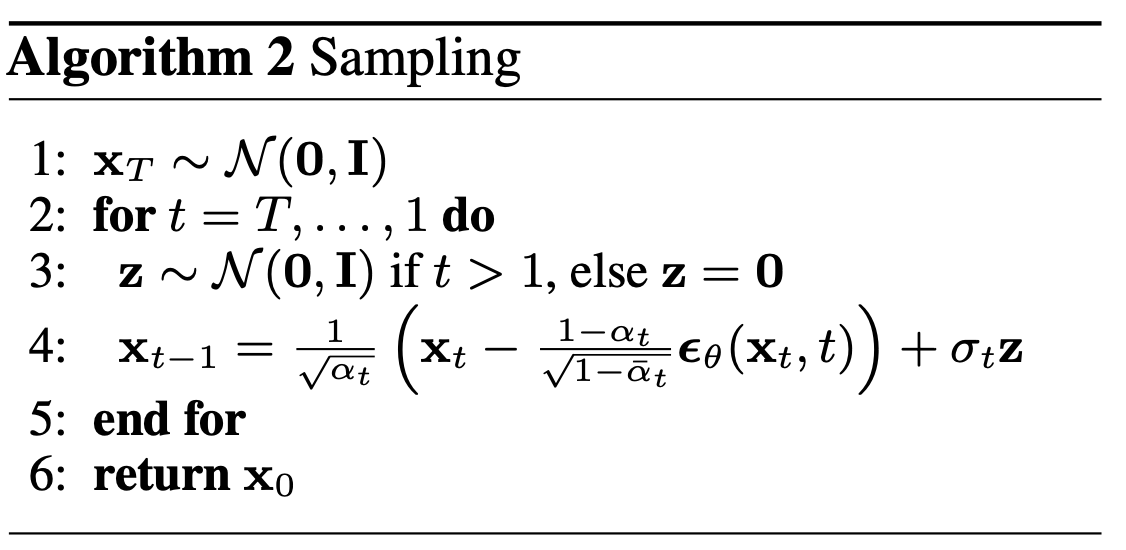

In [39]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    p_sample function for reverse process
    :param model: torch.nn.Module
    :param x: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size,)
    :param t_index: int
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #model prediction
    predicted_noise = model(x, t)
    
    #parameters needed for the sampling formula
    beta_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    #mean of the posterior distribution
    model_mean = sqrt_recip_alphas_t * (x - beta_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
    
    #for the final timestep, return only the mean
    if t_index == 0:
        return model_mean
    else:
        sigma_t = torch.sqrt(beta_t)
        noise = torch.randn_like(x)
        return model_mean + sigma_t * noise
        #### DONE WITH SOLUTION ####


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



## Train the model

Implement training algorithm 1 from the original paper: 

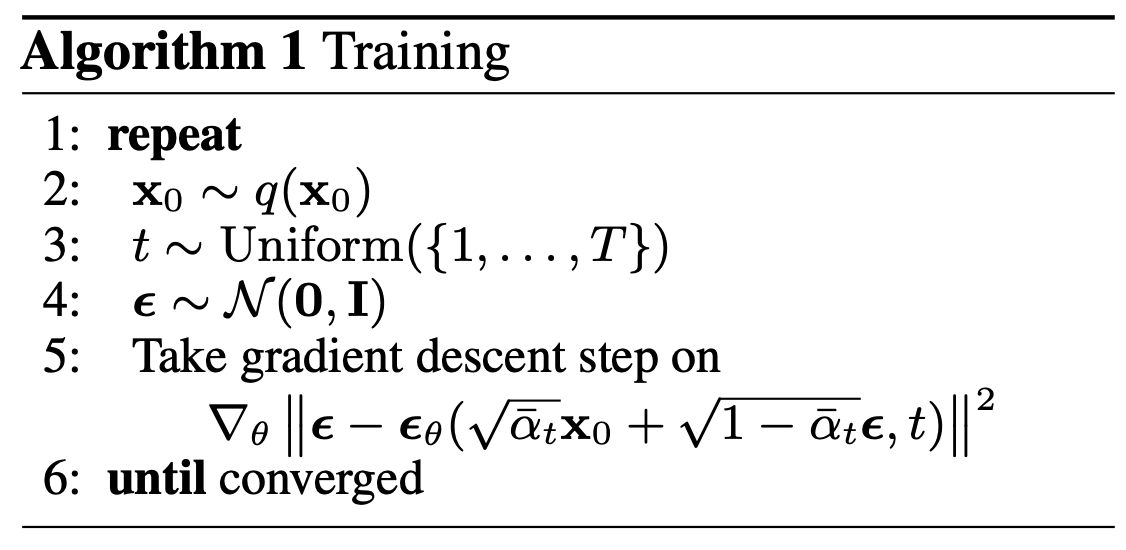

In [40]:
from torch.optim import Adam
#changed

device = "cuda" if torch.cuda.is_available() else "cpu"
channels = 1
image_size = 32

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)

In [41]:
from torchvision.utils import save_image
from pathlib import Path

#### ADD YOUR CODE HERE ####
from tqdm.auto import tqdm
import numpy as np
import random
import torch


timesteps = 1000
# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1.0 - betas

# alpha_bar_t
alphas_cumprod = torch.cumprod(alphas, dim=0)

# alpha_bar_t-1, with alpha_0 = 1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# reproducibility
seed_num = 826
torch.manual_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# save samples on Kaggle
model_folder = Path("/kaggle/working/samples")
model_folder.mkdir(parents=True, exist_ok=True)

epochs = 50

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()
        x_start = batch.to(device)
        t = torch.randint(0, timesteps, (x_start.shape[0],), device=device)
        loss = p_losses(model, x_start, t, loss_type="l2")
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            percent = (step + 1) / len(train_dataloader) * 100
            print(f"Step {step+1}/{len(train_dataloader)} ({percent:.2f}%) - Loss: {loss.item():.4f}")

    # save model checkpoint (overwrite if desired)
    model_path = model_folder / f"model_unet_latest_30_epochs_{seed_num}.pth"
    torch.save(model.state_dict(), model_path)
#### DONE WITH SOLUTION ####        



Epoch 1/50
Step 1/1094 (0.09%) - Loss: 1.5006
Step 101/1094 (9.23%) - Loss: 0.1814
Step 201/1094 (18.37%) - Loss: 0.1352
Step 301/1094 (27.51%) - Loss: 0.1243
Step 401/1094 (36.65%) - Loss: 0.0700
Step 501/1094 (45.80%) - Loss: 0.0640
Step 601/1094 (54.94%) - Loss: 0.0632
Step 701/1094 (64.08%) - Loss: 0.0843
Step 801/1094 (73.22%) - Loss: 0.0764
Step 901/1094 (82.36%) - Loss: 0.1010
Step 1001/1094 (91.50%) - Loss: 0.0690
Epoch 2/50
Step 1/1094 (0.09%) - Loss: 0.0686
Step 101/1094 (9.23%) - Loss: 0.0587
Step 201/1094 (18.37%) - Loss: 0.0442
Step 301/1094 (27.51%) - Loss: 0.0571
Step 401/1094 (36.65%) - Loss: 0.0675
Step 501/1094 (45.80%) - Loss: 0.0855
Step 601/1094 (54.94%) - Loss: 0.0513
Step 701/1094 (64.08%) - Loss: 0.0732
Step 801/1094 (73.22%) - Loss: 0.0488
Step 901/1094 (82.36%) - Loss: 0.0630
Step 1001/1094 (91.50%) - Loss: 0.0482
Epoch 3/50
Step 1/1094 (0.09%) - Loss: 0.0595
Step 101/1094 (9.23%) - Loss: 0.0724
Step 201/1094 (18.37%) - Loss: 0.0587
Step 301/1094 (27.51%) - Lo

# Sampling (inference)

To sample from the model, you can just use the sample function defined above.

### Sample at least 64 images for submission.

### The zip file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).

### Images within the zip should be .png or .jpg.


In [42]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

#### ADD YOUR CODE HERE ####
import os
import zipfile
from pathlib import Path
import numpy as np
from PIL import Image

assignment_number = 2
student_id = "318280294"

# 1. Sample images
final_samples = samples[-1]
img_dir = Path("generated_images")
img_dir.mkdir(exist_ok=True)

# 3. Save each image as PNG
for i, img in enumerate(final_samples):
    # Convert from [-1,1] to [0,255] uint8
    if img.shape[0] == 1:
        array = ((img[0] + 1) / 2 * 255).astype(np.uint8)
        pil_img = Image.fromarray(array, mode="L")
    else:
        array = ((np.transpose(img, (1, 2, 0)) + 1) / 2 * 255).astype(np.uint8)
        pil_img = Image.fromarray(array)
    pil_img.save(img_dir / f"sample_{i:02d}.png")

# 4. Create ZIP for submission
zip_name = f"HW{assignment_number}_{student_id}.zip"
with zipfile.ZipFile(zip_name, "w") as zf:
    for img_path in sorted(img_dir.iterdir()):
        zf.write(img_path, arcname=img_path.name)

print(f"Saved 64 images to '{img_dir}/' and created submission ZIP '{zip_name}'")

#### DONE WITH SOLUTION ####

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved 64 images to 'generated_images/' and created submission ZIP 'HW1_318280294.zip'


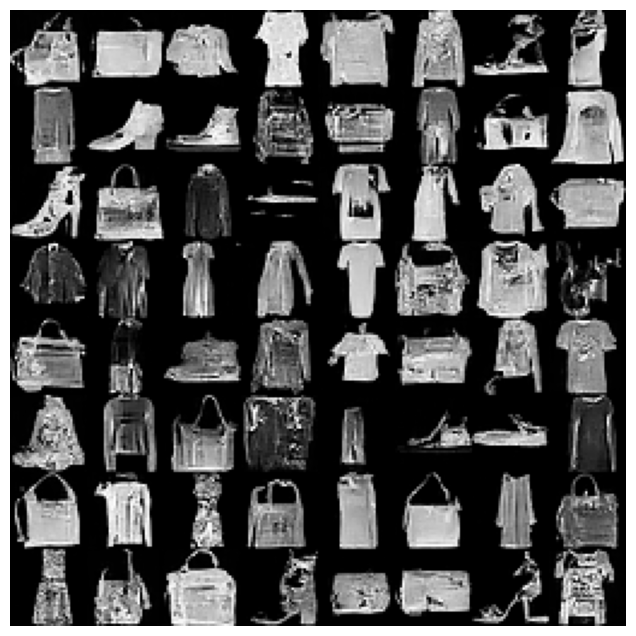

In [43]:
#Creating grid of all images
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

final_images = samples[-1]  # shape: [64, 1, H, W] if grayscale

# Convert to tensor and rescale from [-1, 1] to [0, 1]
final_images = torch.tensor(final_images)
final_images = (final_images + 1) / 2
final_images = final_images.clamp(0, 1)

# Create a grid of images with no padding
grid_img = make_grid(final_images, nrow=8, padding=0)  # shape: [1, H_total, W_total]

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')  # permute to [H, W, C]
plt.axis("off")
plt.show()

Run the following code to show us the denoising process 
Or Create an animation of the denoising process - for a specific sample <random_index>:

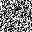

In [44]:
import imageio
import numpy as np
from torchvision.transforms import ToPILImage
import torch
from IPython.display import Image as IPyImage, display
from PIL import Image

to_pil = ToPILImage()

random_index = 9

frames = []

for i in range(timesteps):
    img_array = samples[i][random_index]  # assumed shape [C, H, W]

    if isinstance(img_array, np.ndarray):
        img_array = (img_array + 1) / 2
        img_array = np.clip(img_array, 0, 1)
        img_tensor = torch.from_numpy(img_array)
    else:
        img_tensor = (img_array + 1) / 2
        img_tensor = img_tensor.clamp(0, 1)

    img = to_pil(img_tensor)
    frames.append(np.array(img))

gif_path = "diffusion.gif"
imageio.mimsave(
    gif_path,
    frames,
    duration=0.05,  # Slightly slower = fewer frames per second = faster to write
    loop=0,
    subrectangles=True  # <<< speeds up encoding if supported
)

display(IPyImage(filename="diffusion.gif", width=128, height=128))